 # Customer Segmentation Using RFM Analysis

In [1]:
# import ibraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load & Explore Data
df = pd.read_csv("Online Retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# Missing Values Handeling & Data Cleaning
df = df.dropna(subset=["Description","CustomerID"])

In [7]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
# Change InvoiceDate Data Type
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [9]:
# Delete Returns
# Any invoice with a beginning with "C" indicates that it is a return.
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

In [10]:
# Add Revenue Column
df["Revenue"] = df["Quantity"] * df["UnitPrice"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [11]:
# Define Reference Date
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [12]:
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

In [13]:
# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'Revenue': 'sum'                                          # Monetary
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [14]:
# Assign RFM scores using quartiles

# Recency
rfm['R_Score'] = pd.cut(rfm['Recency'],
                        bins=[-1, 30, 90, 180, rfm['Recency'].max()],
                        labels=[4,3,2,1])

# Frequency
rfm['F_Score'] = pd.cut(rfm['Frequency'],
                        bins=[0, 1, 3, 6, rfm['Frequency'].max()],
                        labels=[1,2,3,4],
                        include_lowest=True)

# Monetary
rfm['M_Score'] = pd.cut(rfm['Monetary'],
                        bins=[0, 100, 500, 1000, rfm['Monetary'].max()],
                        labels=[1,2,3,4],
                        include_lowest=True)

In [15]:
# Combine Scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score']   = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

In [16]:
# Define customer segments based on RFM Score
def segment_customer(score):
    if score >= 9:
        return 'Champions'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalist'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6,Potential Loyalist
12347.0,2,7,4310.00,4,4,4,444,12,Champions
12348.0,75,4,1797.24,3,3,4,334,10,Champions
12349.0,19,1,1757.55,4,1,4,414,9,Champions
12350.0,310,1,334.40,1,1,2,112,4,At Risk


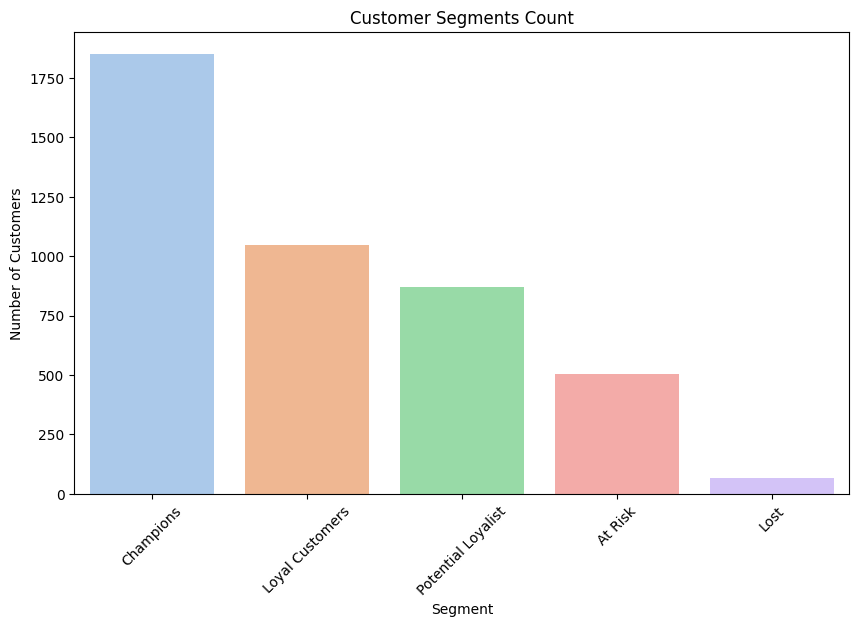

In [20]:
# Bonus - Visualization & Insights

segment_counts = rfm['Segment'].value_counts()

# Bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="pastel")
plt.title("Customer Segments Count")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.savefig("Customer Segments Count.png", dpi=300, bbox_inches='tight')
plt.show()

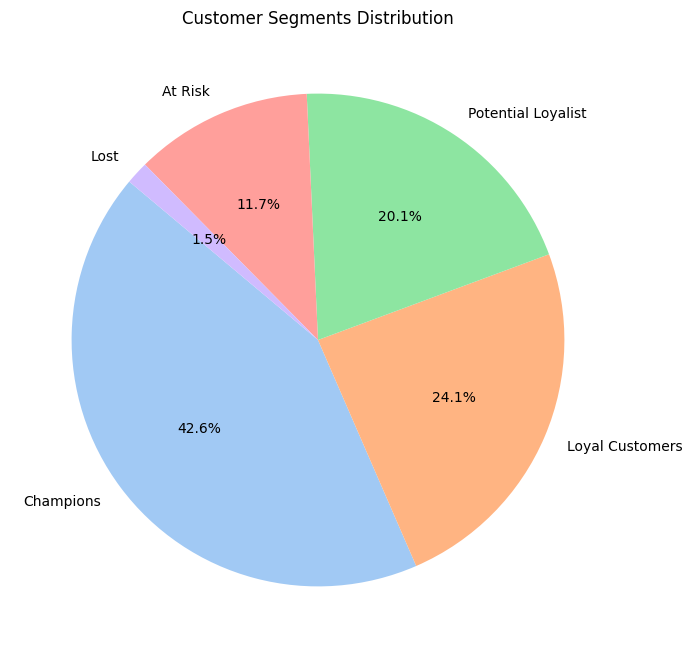

In [19]:
# Pie chart
plt.figure(figsize=(8,8))
segment_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Customer Segments Distribution")
plt.ylabel("")
plt.savefig("Customer Segments Distribution.png", dpi=300, bbox_inches='tight')
plt.show()